# ML-model initialisation and execution

In [1]:
from copro import utils, pipeline, evaluation, plots

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.5b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


## Read pre-computed XY-data

In the cfg-file, all the settings for the analysis are defined. By 'parsing' (i.e. reading) it, all settings and file paths are known to the model. This is a simple way to make the code independent of the input data and settings.

In [3]:
settings_file = 'example_settings.cfg'

Based on this cfg-file, the set-up of the run can be initialized. One part of the cfg-file is the specification and creation of an output folder.

In [4]:
config, out_dir = utils.initiate_setup(settings_file)

saving output to folder C:\Users\hoch0001\Documents\_code\copro\example\OUT

no conflict file was specified, hence downloading data from http://ucdp.uu.se/downloads/ged/ged201-csv.zip to C:\Users\hoch0001\Documents\_code\copro\example\example_data\UCDP\ged201-csv.zip



Since no XY-data is specified in the config-file initially, we have to set this manually.

In [5]:
config.set('pre_calc', 'XY', str(os.path.join(os.path.abspath(config.get('general', 'input_dir')), 'XY.npy')))

See if the right path pops up:

In [6]:
config.get('pre_calc', 'XY')

'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\example_data\\XY.npy'

Now that this is taken care of, we also need to load in the data from the very first notebook.

In [7]:
conflict_gdf = gpd.read_file(os.path.join(out_dir, 'selected_conflicts.shp'))
selected_polygons_gdf = gpd.read_file(os.path.join(out_dir, 'selected_polygons.shp'))

Again, for the conversion from numpy array to dataframe this requires a few more steps.

In [8]:
global_arr = np.load(os.path.join(out_dir, 'global_df.npy'), allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

The scence is set now and we can compute the X-array and Y-array in no time!

In [9]:
X, Y = pipeline.create_XY(config, conflict_gdf, selected_polygons_gdf)

loading XY data from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\XY.npy

number of data points including missing values: 4110
number of data points excluding missing values: 4005
from this, 619 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 15.46 percent.


## Scaler and classifier

In [10]:
scaler, clf = pipeline.prepare_ML(config)

chosen scaling method is QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)
chosen ML model is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={1: 100},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


## Output initialization

Since the model is run multiple times, we need to initialize some stuff first to append the output per run.

In [11]:
out_X_df = evaluation.init_out_df()
out_y_df = evaluation.init_out_df()

In [12]:
out_dict = evaluation.init_out_dict()

In [13]:
trps, aucs, mean_fpr = evaluation.init_out_ROC_curve()

## ML-model execution

The pudels kern! This is where the magic happens, and not only once. Due make sure that any conincidental results are ruled out, we run the model multiple times. Thereby, always different samples are used for training and prediction. By using a sufficient number of runs and averaging the overall results, we should be able to get a good picture of what the model is capable of.

The main evaluation metric is the mean ROC-score and [**ROC-curve**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html), plotted at the end of all runs.

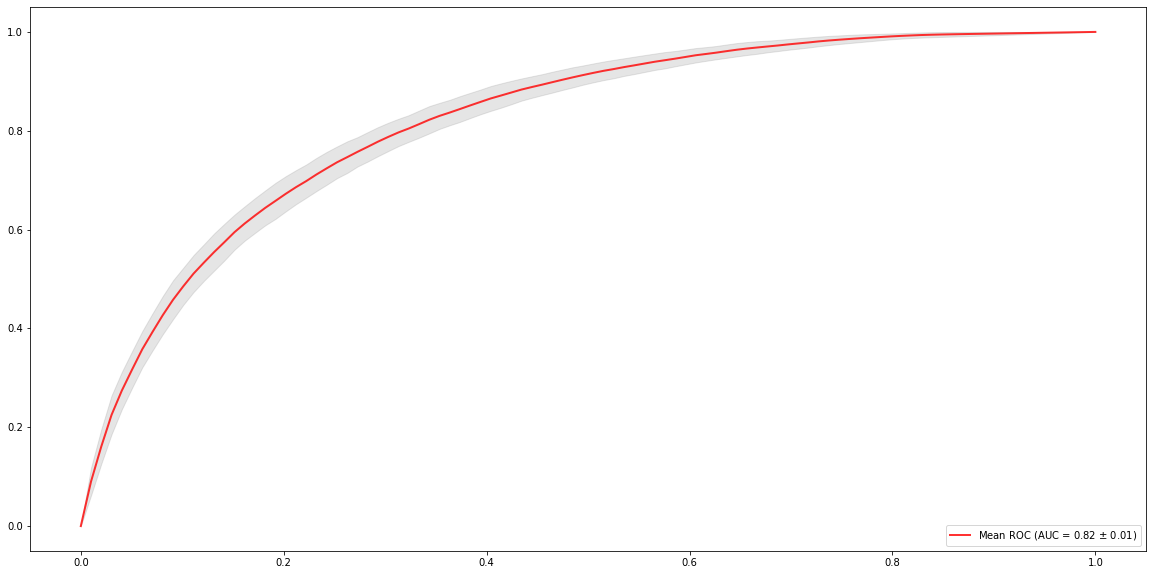

In [26]:
# #- create plot instance
fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

#- go through all n model executions
for n in range(config.getint('settings', 'n_runs')):
    
    if config.getboolean('general', 'verbose'):
        print('run {} of {}'.format(n+1, config.getint('settings', 'n_runs')) + os.linesep)

    #- run machine learning model and return outputs
    X_df, y_df, eval_dict = pipeline.run(X, Y, config, scaler, clf, out_dir)
    
    #- select sub-dataset with only datapoints with observed conflicts
    X1_df, y1_df = utils.get_conflict_datapoints_only(X_df, y_df)
    
    #- append per model execution
    out_X_df = evaluation.fill_out_df(out_X_df, X_df)
    out_y_df = evaluation.fill_out_df(out_y_df, y_df)
    out_dict = evaluation.fill_out_dict(out_dict, eval_dict)

    #- plot ROC curve per model execution
    tprs, aucs = plots.plot_ROC_curve_n_times(ax1, clf, X_df.to_numpy(), y_df.y_test.to_list(),
                                                                  trps, aucs, mean_fpr)

#- plot mean ROC curve
plots.plot_ROC_curve_n_mean(ax1, tprs, aucs, mean_fpr)

## Model evaluation

### For all data points

During the model runs, the computed model evaluation scores per model execution were stored to a dictionary. Currently, the evaluation scores used are:

* [**Accuracy**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): the fraction of correct predictions;
* [**Precision**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative;
* [**Recall**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html): the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples;
* [**F1 score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): the F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0;
* [**Cohen-Kappa score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html): is used to measure inter-rater reliability. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.
* [**Brier score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html): the smaller the Brier score, the better, hence the naming with “loss”. The lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier loss score is relatively sensitive for imbalanced datasets;
* [**ROC score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): a value of 0.5 suggests no skill, e.g. a curve along the diagonal, whereas a value of 1.0 suggests perfect skill, all points along the left y-axis and top x-axis toward the top left corner. A value of 0.0 suggests perfectly incorrect predictions. Note that the ROC score is relatively insensitive for imbalanced datasets.

Let's check the mean scores over all runs:

In [27]:
for key in out_dict:
    
    print('average {0} of run with {1} repetitions is {2:0.3f}'.format(key, config.getint('settings', 'n_runs'), np.mean(out_dict[key])))

average Accuracy of run with 50 repetitions is 0.854
average Precision of run with 50 repetitions is 0.558
average Recall of run with 50 repetitions is 0.263
average F1 score of run with 50 repetitions is 0.356
average Cohen-Kappa score of run with 50 repetitions is 0.285
average Brier loss score of run with 50 repetitions is 0.107
average ROC AUC score of run with 50 repetitions is 0.820


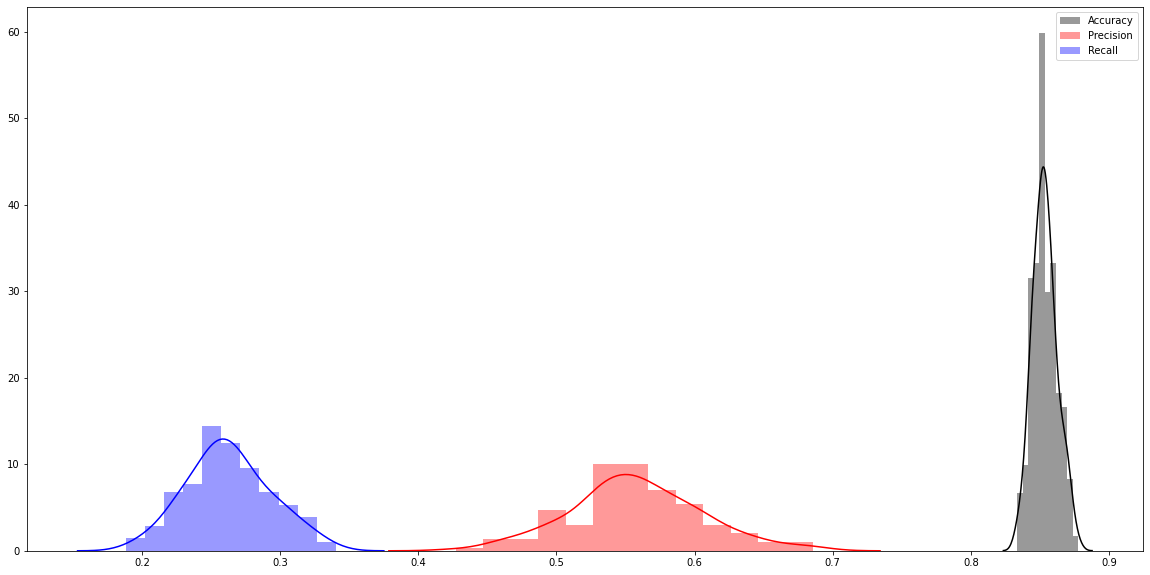

In [28]:
plots.metrics_distribution(out_dict, figsize=(20, 10));

Based on all data points, the [**confusion matrix**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) can be plotted. This is a relatively straightforward way to visualize how good the classifier values are predicted by the model.

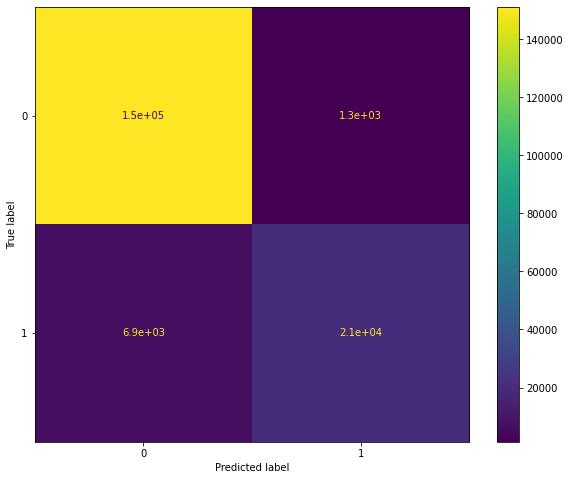

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
metrics.plot_confusion_matrix(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax);

### Per unique polygon

Thus far, we merely looked at numerical scores. This of course tells us a lot about the quality of the machine-learning model and its predictions, but not so much about how this looks like spatially. We therefore combine the observations and predictions made with the associated polygons based on a 'global' dataframe functioning as a look-up table. By this means, each model output can be connected to its polygon using a unique ID.

In [30]:
df_hit, gdf_hit = evaluation.polygon_model_accuracy(out_y_df, global_df, out_dir=None)

First, let's have a look at how often each polygon occurs in the all test samples, i.e. those obtained by appending the test samples per model execution. Besides, the overall relative distribution is visualized.

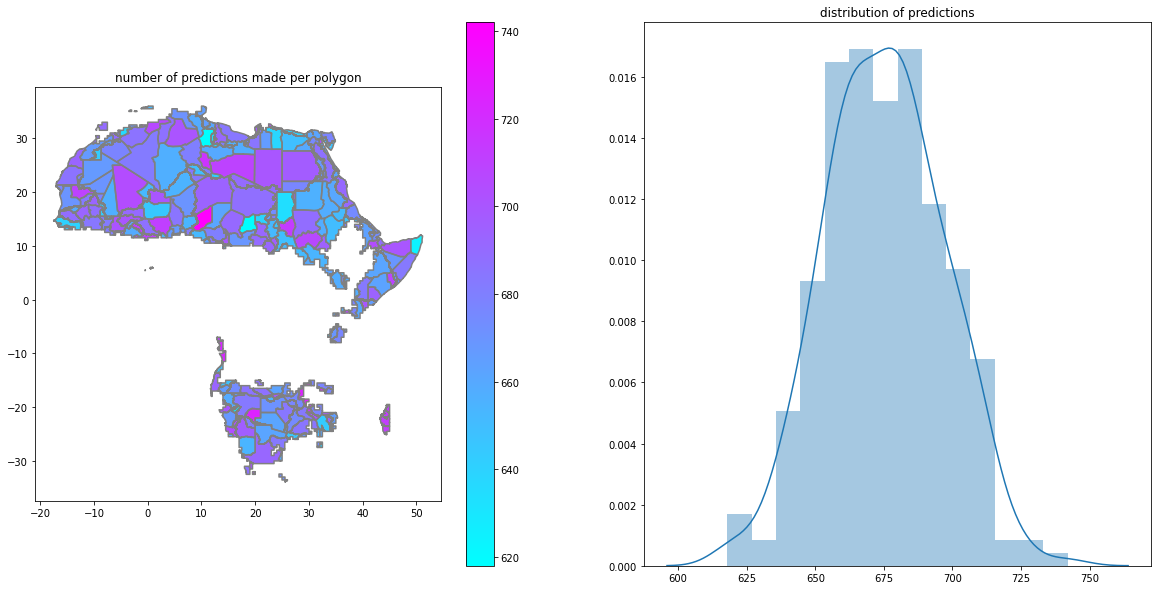

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='ID_count', legend=True, cmap='cool')
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit.ID_count.values, ax=ax2)
ax2.set_title('distribution of predictions');

By repeating the model n times, the aim is to represent all polygons in the resulting test sample. The fraction is computed below. 

Note that is should be close to 100 % but may be slightly less. This can happen if input variables have no data for one polygon, leading to a removal of those polygons from the analysis. Or because some polygons and input data may not overlap.

In [32]:
print('{0:0.2f} % of all active polygons are considered in test sample'.format(len(gdf_hit)/len(selected_polygons_gdf)*100))

97.45 % of all active polygons are considered in test sample


By aggregating results per polygon, we can now assess model output spatially. Three main aspects are presented here:

1. The chance of a correct prediction, defined as the ratio of number of correct predictions made to overall number of predictions made;
2. The total number of conflicts in the test data;
3. The chance of conflict, defined as the ration of number of conflict predictions to overall number of predictions made.

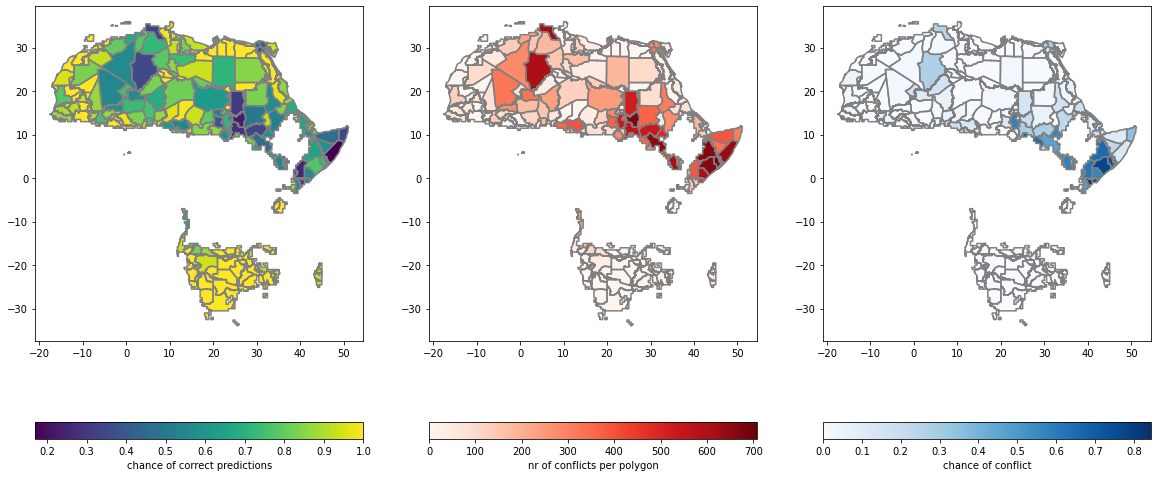

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='chance_correct_pred', legend=True, 
             legend_kwds={'label': "chance of correct predictions", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
gdf_hit.plot(ax=ax2, column='nr_test_confl', legend=True, cmap='Reds', 
             legend_kwds={'label': "nr of conflicts per polygon", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax2, color='0.5')
gdf_hit.plot(ax=ax3, column='chance_correct_confl_pred', legend=True, cmap='Blues', 
             legend_kwds={'label': "chance of conflict", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax3, color='0.5');

To get the variation of CCP (chance of corret prediction) per polygon, we split up the entire output data in 10 parts and calcualte mean, median, and standard deviation of CCP.

In [34]:
gdf_CCP = evaluation.calc_kFold_polygon_analysis(out_y_df, global_df, out_dir=None)

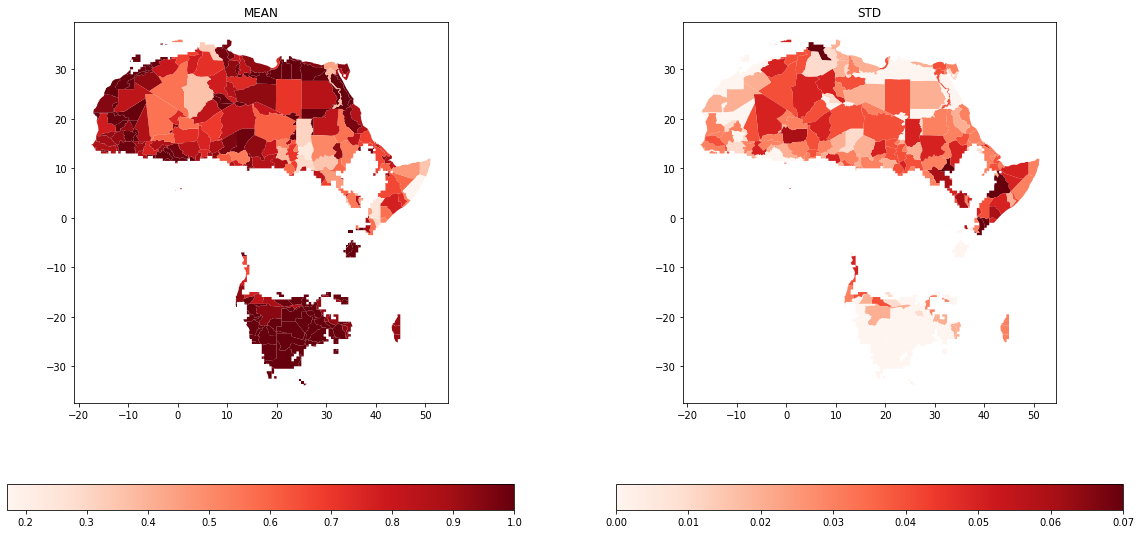

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_CCP.plot(column='mean_CCP', ax=ax1, cmap='Reds', legend=True, legend_kwds={'orientation': "horizontal"})
ax1.set_title('MEAN')
gdf_CCP.plot(column='std_CCP', ax=ax2, cmap='Reds', legend=True, legend_kwds={'orientation': "horizontal"})
ax2.set_title('STD');

To understand to what extent the model accuracy (i.e. hits) may depend on the number of predictions made per polygon or other factors, we plot some simple scatter plots.

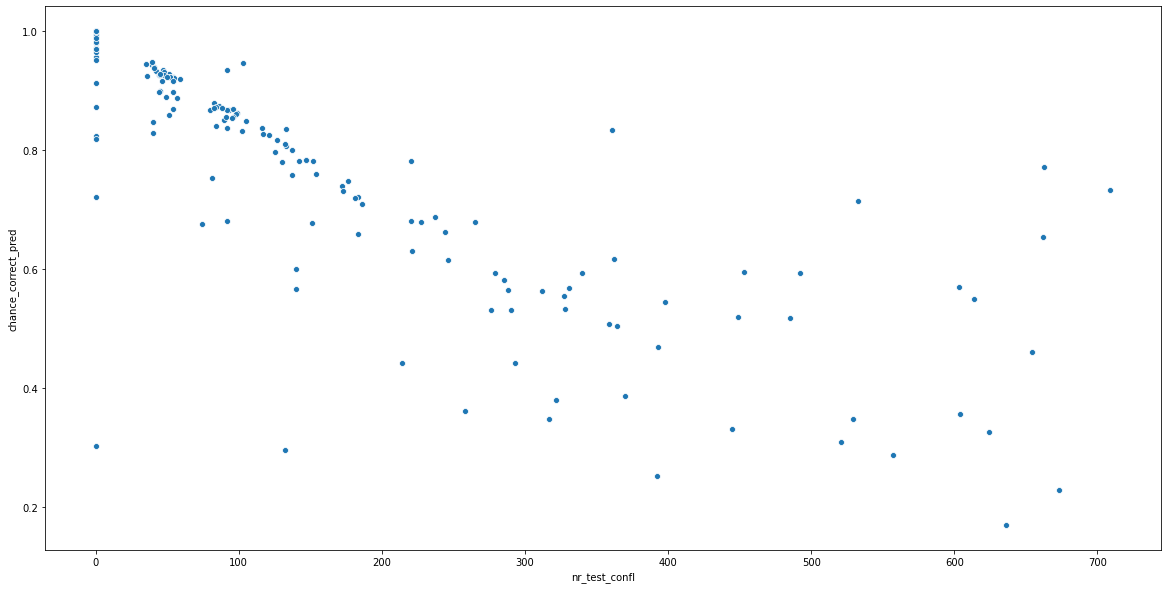

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sbs.scatterplot(data=df_hit, x='nr_test_confl', y='chance_correct_pred', ax=ax)

Up to know, we looked at two or more indicators of how the model performed and other statistical analyses per polygon. It's now time to come up with an indicator for which polygons we 'trust' the model.

Thus, we compute the median of the average hit accuracy of all polygons. This allows for dividing the polygons in the 50 % with an average hit accuracy above the median, and the other 50 % below it. These are our main categories:

* 'H': upper 50 % of average hit accuracy;
* 'L': lower 50 % of average hit accuracy.

In addition, we may want to know how this categorization depends on the number of conflicts in a polygon. For example, wich polygons have a high accuracy with lots of conflicts? For these polygons, we could assume that the model robustly succeeds in predicting conflict. To that end, we also compute the median number of conflicts per polygon.

This yields four sub-categories:

* 'HH': upper 50 % of average hit accuracy and upper 50 % of number of conflicts;
* 'HL': upper 50 % of average hit accuracy, but then with lower 50 % of number of conflicts;
* 'LH': lower 50 % of average hit accuracy and upper 50 % of number of conflicts;
* 'LL': lower 50 % of average hit accuracy, but then with lower 50 % of number of conflicts.

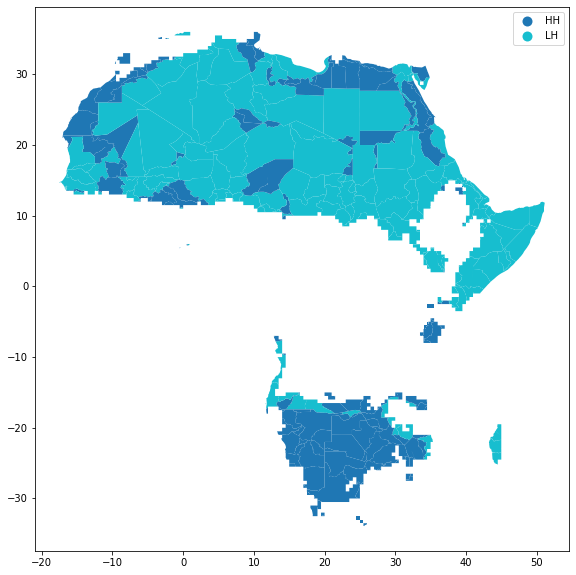

In [39]:
plots.polygon_categorization(gdf_hit, category='sub', figsize=(20, 10), legend=True);

Last, we can determine the relative importance of each feature, that is variable.

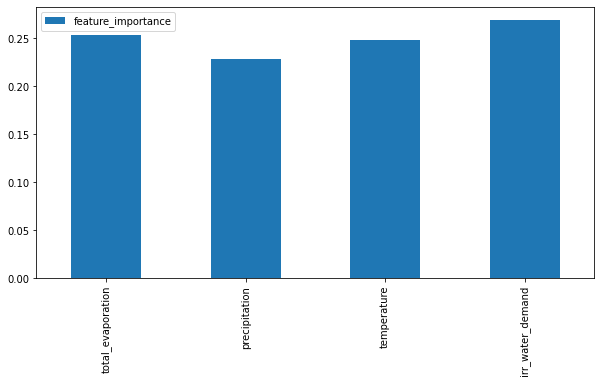

In [47]:
plots.factor_importance(clf, config, out_dir, figsize=(10, 5));